In [1]:
import os
os.chdir(os.path.expanduser('~/My Drive/msc-thesis/core'))

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import math
import itertools
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from glob import glob
from tqdm.auto import tqdm
from jax import vmap
from jax.tree_util import tree_map, tree_leaves
import models, datasets, distributions, utils

In [4]:
# load dataset
ds_name = 'mnist'
x_train, y_train, n_class = datasets.load(ds_name, 'train')
x_test,  y_test,  n_class = datasets.load(ds_name, 'test')
ds_key = jax.random.PRNGKey(0)
x_train, y_train = utils.subsample_dataset(ds_key, x_train, y_train, n_class, samples_per_class=100)

In [5]:
def bootstrap(key, data, f, fraction=0.3):
    """vectorized bootstrap sampling"""
    # generate data batches
    n_samples = math.ceil(fraction * len(data))
    bootstrap_samples = jax.random.choice(key, data, (n_samples, len(data)))

    # evaluate function for each batch
    vals = vmap(f)(bootstrap_samples)

    # return distribution summary (median ±1 st dev)
    median = jnp.median(vals)
    lower = jnp.percentile(vals, 25)
    upper = jnp.percentile(vals, 75)
    std = jnp.std(vals)
    return float(median), float(lower), float(upper), float(std)

In [6]:
%%time
def get_metrics(key, logits, y):
    k1, k2 = jax.random.split(key)
    
    # ensemble accuracy
    # def f(logits):
    #     logprobs = utils.average_predictions(logits)
    #     ens_acc = (logprobs.argmax(1) == y).mean()
    #     return ens_acc
    # acc = bootstrap(k1, logits, f)
    
    # sample accuracy
    def f(logits):
        logprobs = jax.nn.log_softmax(logits)
        ens_acc = (logprobs.argmax(-1) == y[None]).mean()
        return ens_acc
    acc = bootstrap(k1, logits, f)
    
    # sample confidence
    f = lambda logits: jax.nn.softmax(logits).max(-1).mean(-1)
    conf = bootstrap(k2, logits, f)
    
    return acc, conf

# load all models into pandas dataframe
key = jax.random.PRNGKey(0)
df = []
safe = lambda f, x: None if x == 'None' else f(x)
for model_dir in tqdm(glob(os.path.expanduser('~/Downloads/weights_dirichlet/*seed=0'))):
    
    # get model config
    model_name = model_dir.rsplit('/', 1)[1]
    config = {x.split('=')[0]:x.split('=')[1] for x in model_name.split(',')}
    config['distribution'], config['distribution_param'] = config['distribution'].rsplit('-', 1)
    config['distribution_param'] = safe(float, config['distribution_param'])
    config['std'] = safe(float, config['std'])
    config['temp'] = safe(float, config['T']); del config['T']
    config['augment'] = config['augment'] == 'True'
    config['posterior'] = config['posterior'] == 'True'
    del config['seed']

    # load data for all seeds
    # chain = []
    logits_train = []
    # logits_test = []
    for i in itertools.count():
        seed_dir = f'{model_dir[:-1]}{i}'
        if not os.path.isdir(seed_dir): break
        # chain += [jnp.load(f'{seed_dir}/chain.npy', allow_pickle=True).item()]
        logits_train += [jnp.load(f'{seed_dir}/logits_train.npy')]
        # logits_test += [jnp.load(f'{seed_dir}/logits_test.npy')]
    # chain = tree_map(lambda *trees: jnp.concatenate(trees), *chain)
    logits_train = jnp.concatenate(logits_train)
    # logits_test = jnp.concatenate(logits_test)
    ens_size = len(logits_train)

    # compute metrics
    key, key_train, key_test = jax.random.split(key, 3)
    acc_train, conf_train = get_metrics(key_train, logits_train, y_train)
    # acc_test, conf = get_metrics(key_test, logits_test, y_test)
    # n_param = sum(math.prod(x.shape[1:]) for x in jax.tree_util.tree_leaves(chain))
    # weights_norm = vmap(lambda params: sum(tree_map(lambda x: (x**2).sum()/n_param, tree_leaves(params))))(chain).mean()

    # save model to dataframe
    df += [{**config, **dict(acc_train=acc_train, conf_train=conf_train, ens_size=ens_size,
            # weights_norm=weights_norm, n_param=n_param, acc_test=acc_test
        )}]
    
df = pd.DataFrame.from_dict(df)
# df = df.sort_values(by=['posterior', 'distribution_param']) # ascending=[True, True]
df.head()

  0%|          | 0/82 [00:00<?, ?it/s]

CPU times: user 24.3 s, sys: 3.55 s, total: 27.9 s
Wall time: 11.7 s


,model,ds,samples,distribution,std,posterior,augment,distribution_param,temp,acc_train,conf_train,ens_size
0,cnn,mnist,100,dirichlet-partial,None,False,False,0.001000,1.0,"(0.09924999624490738, 0.0983937457203865, 0.10...","(0.21113544702529907, 0.18648730218410492, 0.2...",80
1,cnn,mnist,100,dirichlet-jac,None,True,False,0.002154,1.0,"(0.9902437329292297, 0.9888874888420105, 0.990...","(0.9993613958358765, 0.9988293647766113, 0.999...",80
2,mlp,mnist,100,dirichlet-jac,None,False,False,0.001000,1.0,"(0.10336874425411224, 0.10244374722242355, 0.1...","(0.9975600838661194, 0.9928308129310608, 0.999...",80
3,mlp,mnist,100,dirichlet-partial,None,False,False,0.046390,1.0,"(0.10204999148845673, 0.10148437321186066, 0.1...","(0.12499067932367325, 0.12028682231903076, 0.1...",80
4,mlp,mnist,100,dirichlet-partial,None,True,False,0.999000,1.0,"(0.2925249934196472, 0.28411874175071716, 0.30...","(0.11819668114185333, 0.1160048171877861, 0.12...",80


In [7]:
# compute expected prior confidence
def get_conf(alpha_prior):
    # y_one_hot = jax.nn.one_hot(0, n_class)
    # alpha = alpha_prior + y_one_hot
    alpha = alpha_prior * jnp.ones(n_class)
    probs = jax.random.dirichlet(key, alpha, [10_000])
    conf = probs.max(-1)
    return conf.mean()
n_class = 10
key = jax.random.PRNGKey(0) 
alpha_theory = jnp.geomspace(0.001, 0.999, 30)
conf_theory = jax.lax.map(get_conf, alpha_theory)

In [8]:
def remove_zeros(x, decimals=4):
    """
    Rounds and removes zeros:
    100.0001 -> 100
    1.000001 -> 1
    0.100001 -> 0.1
    """
    x = np.round(float(x), decimals=decimals)
    s = str(x)
    if s[-2:] == '.0': s = s[:-2]
    return s

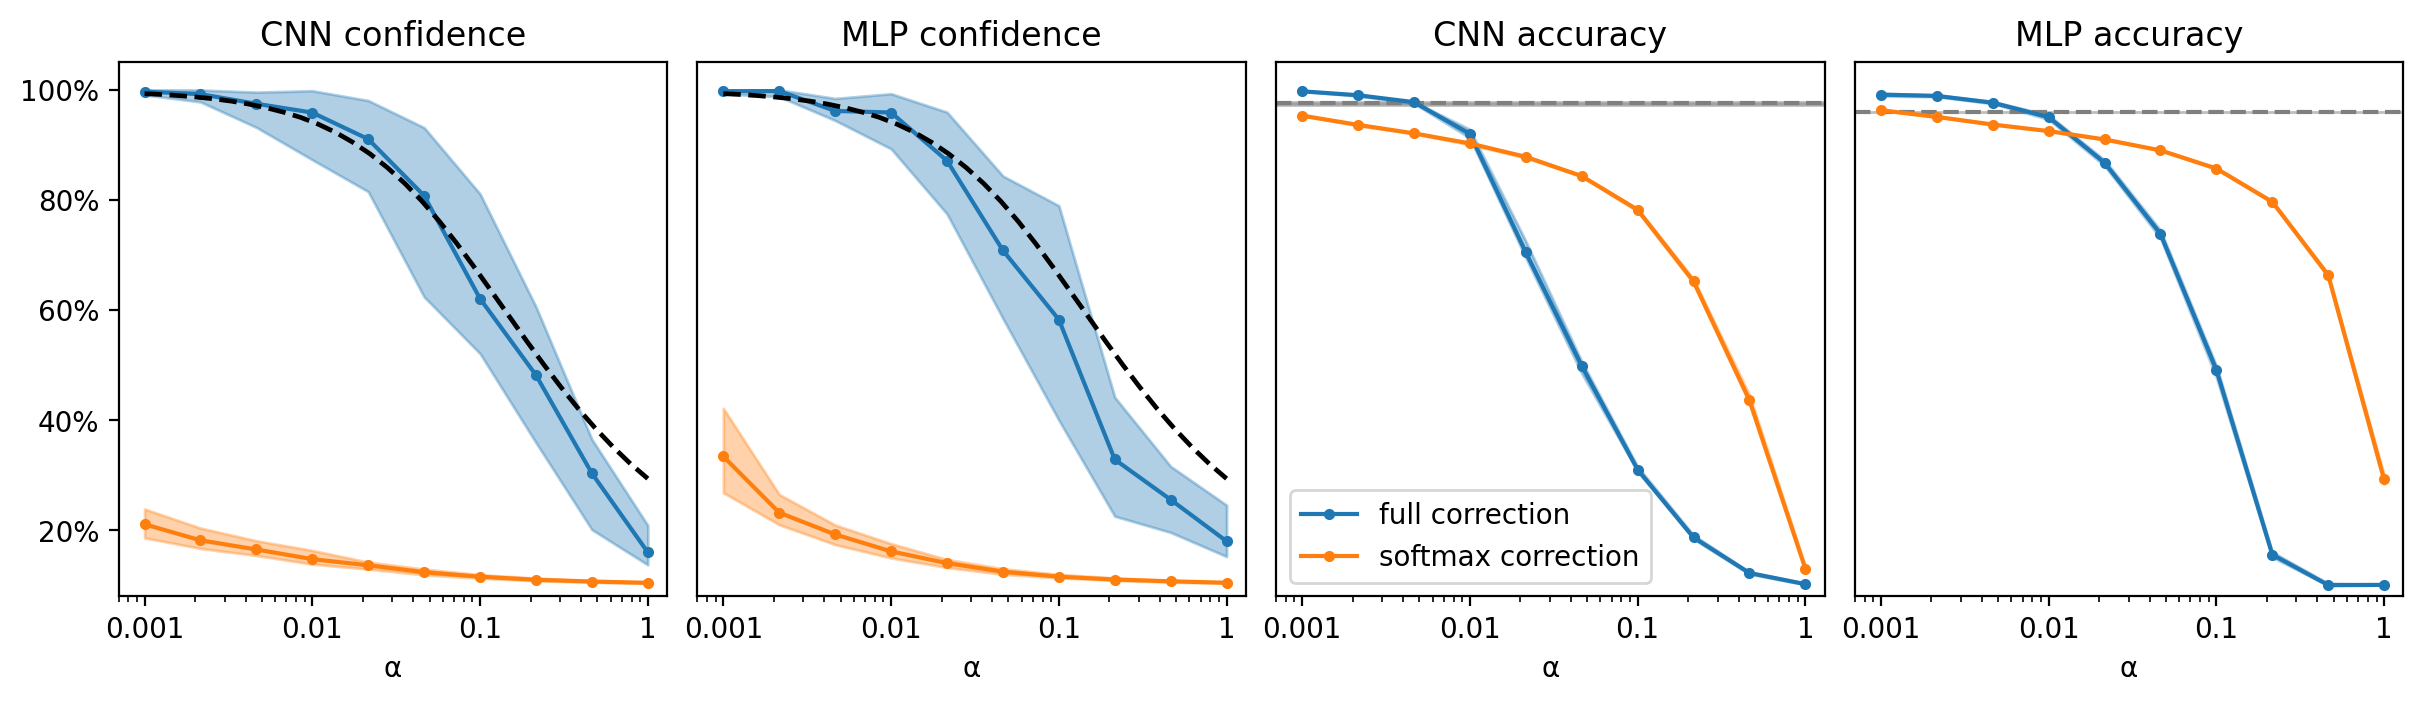

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3.4), layout='constrained')

# loop over models
for i, model in enumerate(('cnn', 'mlp')):
    
    # either plot [prior confidence] or [posterior accuracy]
    for j, (metric, posterior) in enumerate((('conf_train', False), ('acc_train', True))):
        ax = axs[2*j+i]
        
        # uniform prior
        if posterior:
            df_subset = df[(df.model==model) & (df.posterior==posterior) & (df.distribution=='categorical')]
            y = df_subset[metric].item()
            color = 'tab:gray'
            ax.axhline(y[0], color=color, ls='--', lw=1.5)
            ax.fill_between([0, 2], y[1], y[2], color=color, alpha=0.5)
        
        # dirichlet prior
        for k, correction in enumerate(('jacobian', 'logits')):
            distribution = 'dirichlet-jac' if correction == 'jacobian' else 'dirichlet-partial'
            title = f'{model.upper()} {"accuracy" if metric=="acc_train" else "confidence"}'
            label = f'{"full" if correction=="jacobian" else "softmax"} correction'
            df_subset = df[(df.model==model) & (df.posterior==posterior) & (df.distribution==distribution)]
            alpha = df_subset.distribution_param.to_numpy()
            y = np.stack(df_subset[metric])
            o = np.argsort(alpha)
            color = 'tab:blue' if correction == 'jacobian' else 'tab:orange'
            ax.plot(alpha[o], y[o, 0], '.-', label=label, color=color)
            ax.fill_between(alpha[o], y[o, 1], y[o, 2], color=color, alpha=0.35)
            ax.set_title(title)

# plot expected confidence
for ax in axs[:2]:
    ax.plot(alpha_theory, conf_theory, ls='--', c='black', lw=1.7)
            
for ax in axs:
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(lambda x, _: str(x))
    ax.set_xlim((0.7e-3, 1.3))
    ax.set_ylim((0.08, 1.05))
    ax.xaxis.set_major_formatter(lambda x, _: remove_zeros(x))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    ax.set_xlabel('α')
for ax in axs[1:]:
    ax.set(yticklabels=[])
    ax.tick_params(left=False)

# legend
axs[2].legend()

plt.savefig('../plots/mnist_dirichlet_models.pdf')
plt.show()

In [10]:
# by how many stds is the accuracy of dirichlet prior higher than uniform prior?
dir_mean, *_, dir_std = df[(df.model=='mlp') & (df.posterior==True) & (df.distribution=='dirichlet-jac') & (df.distribution_param==0.001)].acc_train.item()
unif_mean, *_, unif_std = df[(df.model=='mlp') & (df.posterior==True) & (df.distribution=='categorical')].acc_train.item()
print(f'{dir_mean:.1%}, {unif_mean:.1%}')
print((dir_mean - unif_mean) / dir_std)
print((dir_mean - unif_mean) / unif_std)

99.1%, 95.9%
8.763140660771818
43.84891690378451
